# Сравним  следующие топологические метрики: hits_authority, hits_hub, eigenvector.

In [1]:
import numpy as np
import pandas as pd

import requests # for make API requests
from requests.exceptions import HTTPError# to handle the responses

import graph_tool as gt #for make protein networks
from graph_tool import centrality as ct
from graph_tool.draw import graph_draw
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import time #to calculate the time

import argparse #read arguments from the command line
import sys
from function_signature_from_DE_v1 import make_signature_from_DE, get_signature_for_request_in_STRING
from PPI_v1 import PPI_numpy_array

Сначала посчитаем метрики

In [2]:
series_up_genes, series_down_genes = make_signature_from_DE('DATA/Fibroblasts_Induced_Neurons/DE_edgeR_cneuron_fibroblast.txt')

In [3]:
print('список генов с повышенной экспрессией длинной {} : {}'.format(len(series_up_genes), series_up_genes))

список генов с повышенной экспрессией длинной 5642 : AADAC           10.000070
KRTAP1-5         9.682907
MMP3             9.304125
IL6              9.011785
HINT3            8.938839
                  ...    
ADRA2C           1.000672
PSME4            1.000663
CEACAMP7         1.000106
TCEB2            1.000076
RP11-577H5.5     1.000030
Name: logFC, Length: 5642, dtype: float64


In [4]:
print('список генов с пониженной экспрессией длинной {} : {}'.format(len(series_down_genes), series_down_genes))

список генов с пониженной экспрессией длинной 7028 : NEUROD6   -11.440812
HBE1      -10.332124
HBZ       -10.272220
ELAVL4     -9.500666
HBG1       -9.486022
             ...    
ZNF625     -1.000531
SLC17A4    -1.000453
CDC42P5    -1.000367
ARNT2      -1.000270
PYDC2      -1.000137
Name: logFC, Length: 7028, dtype: float64


In [5]:
with open('DATA/Fibroblasts_Induced_Neurons/list_genes_in_string_up_Fibroblasts_Induced_Neurons.txt' , "r") as file:
    up = file.read().split("\n")
print('список генов в STRING с повышенной экспрессией длинной {} : {} ...'.format(len(up), up[0:15]))
with open('DATA/Fibroblasts_Induced_Neurons/list_genes_in_string_down_Fibroblasts_Induced_Neurons.txt', "r") as file:
    down = file.read().split("\n")
print('список генов в STRING с пониженной экспрессией длинной {} : {} ...'.format(len(down), down[0:15]))

список генов в STRING с повышенной экспрессией длинной 2000 : ['AADAC', 'KRTAP1-5', 'MMP3', 'IL6', 'HINT3', 'ANPEP', 'CARD16', 'PSG5', 'CXCL8', 'MMP1', 'LRRC15', 'DPT', 'SERPINB2', 'PSG4', 'MYL7'] ...
список генов в STRING с пониженной экспрессией длинной 2000 : ['NEUROD6', 'HBE1', 'HBZ', 'ELAVL4', 'HBG1', 'SLC17A6', 'DCX', 'HMP19', 'HBG2', 'CARTPT', 'HES5', 'NEUROG1', 'SCGN', 'SOX1', 'ASCL1'] ...


In [6]:
up_interactions_numpy_array = PPI_numpy_array(up, 9606, 0.4)

In [7]:
matrix_up = up_interactions_numpy_array.get_interactions_as_adjacency_matrix()

In [9]:
matrix_up.shape

(2000, 2000)

In [10]:
dict_number_genes = up_interactions_numpy_array.get_dict_number_genes()

In [11]:
graph = gt.Graph(directed=False)
vertex_list = graph.add_vertex(matrix_up.shape[0])
matrix = np.triu(matrix_up)
graph.add_edge_list((np.transpose(matrix.nonzero())))
vprop_name_proteins = graph.new_vertex_property('string')
for i in range(matrix_up.shape[0]):
    vprop_name_proteins[i] = dict_number_genes[i]
graph.vertex_properties['name_proteins'] = vprop_name_proteins

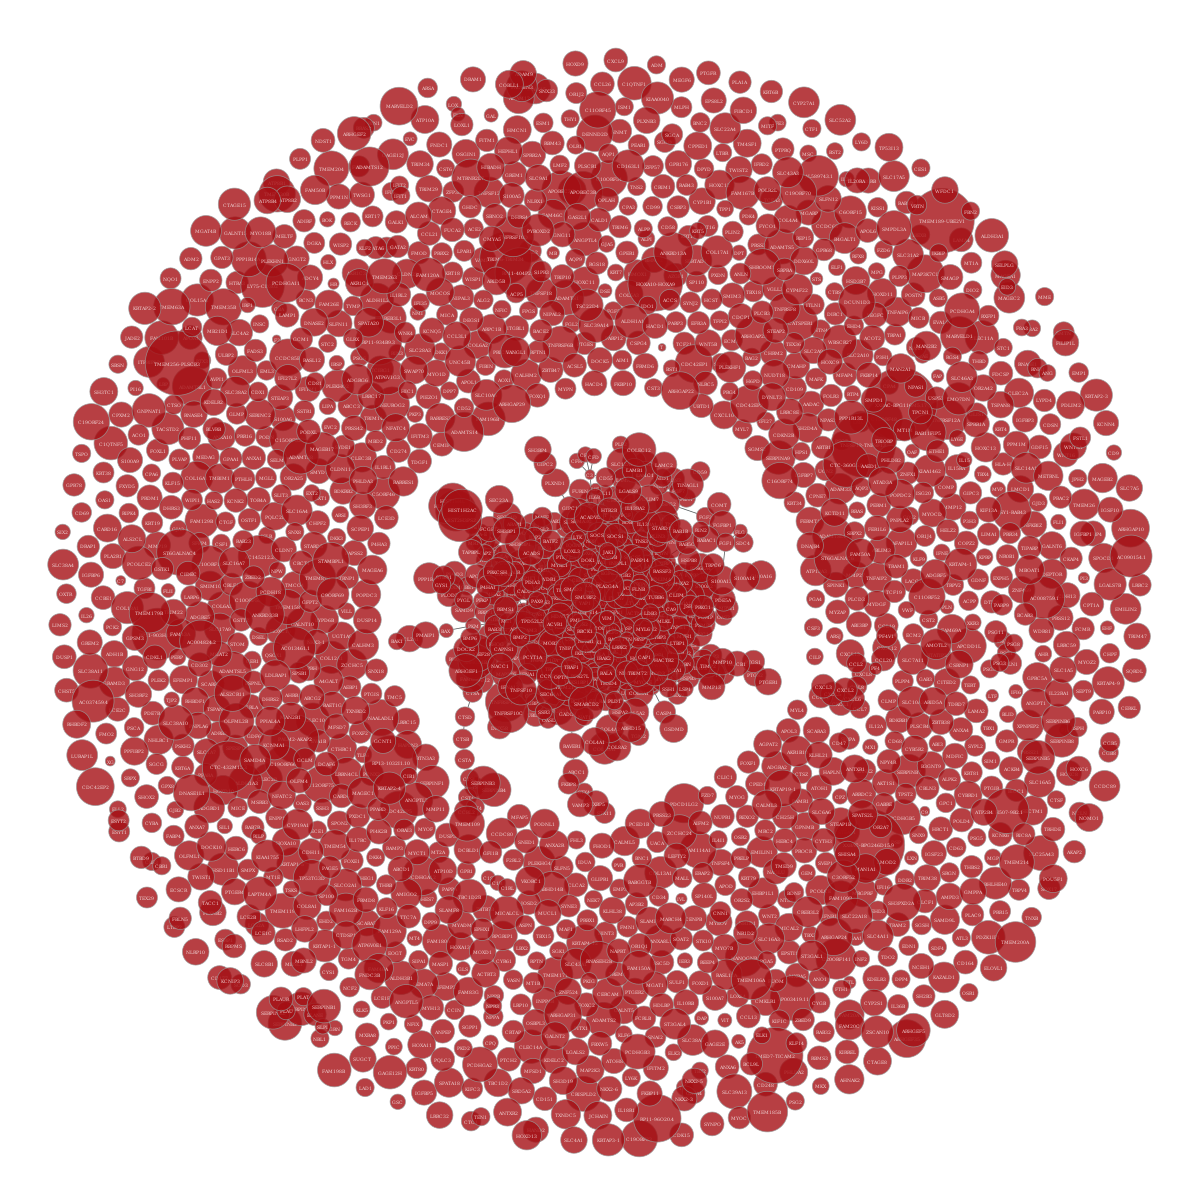

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7fc41af858b0, at 0x7fc401887580>

In [12]:
graph_draw(graph, vertex_text=graph.vertex_properties['name_proteins'])

In [21]:
hits_authority = ct.hits(graph)[1]
hits_authority_list = [x for x in hits_authority]
print(hits_authority_list[0:20])

[0.0, 0.0, 0.0007383550590713435, 0.004363799278676806, 0.0, 0.0, 0.0, 0.0, 7.46760252454725e-59, 0.00012940010236953516, 0.0, 0.0, 4.345945820507945e-70, 1.0753970578298412e-61, 0.0, 0.006507356472354432, 0.0, 0.01292192062844189, 1.5995035465828892e-62, 0.0]


In [22]:
hits_hub = ct.hits(graph)[2]
hits_hub_list = [x for x in hits_hub]
print(hits_hub_list[0:20])

[0.0, 0.0, 0.0007383550590713435, 0.004363799278676808, 0.0, 0.0, 0.0, 0.0, 7.467602524547252e-59, 0.00012940010236953516, 0.0, 0.0, 4.3459458205079486e-70, 1.0753970578298412e-61, 0.0, 0.006507356472354433, 0.0, 0.012921920628441894, 1.5995035465828892e-62, 0.0]


In [23]:
eigenvector = ct.eigenvector(graph)[1]
eigenvector_list = [x for x in eigenvector]
print(eigenvector_list[0:20])

[0.0, 0.0, 0.0007383553677060995, 0.004363801474543923, 0.0, 0.0, 0.0, 0.0, 4.665453527262047e-56, 0.00012940016052162345, 0.0, 0.0, 9.785945663009085e-67, 9.53575218936583e-59, 0.0, 0.00650735165283883, 0.0, 0.012921924205918915, 1.5673662783504344e-59, 0.0]


In [49]:
def compare(vector1, vector2, name_vector1, name_vector2):
    print('число совпавших значений между {} и {}: {} \nчисло отличающихся значений между {} и {} :{} \nмаксимальная разница отличающихся значений : {}'.format(name_vector1, name_vector2, sum([vector1[i] == vector2[i] for i in range(len(vector1))]), name_vector1, name_vector2, sum([vector1[i] != vector2[i] for i in range(len(vector1))]), max([abs(vector1[i] - vector2[i])  for i in range(len(vector1)) if vector1[i] != vector2[i]]))) 

# Сравним hits_authority и hits_hub

In [52]:
compare(hits_authority_list, hits_hub_list, 'hits_authority', 'hits_hub')

число совпавших значений между hits_authority и hits_hub: 1319 
число отличающихся значений между hits_authority и hits_hub :681 
максимальная разница отличающихся значений : 5.551115123125783e-17


# Сравним hits_authority и eigenvector 

In [51]:
compare(hits_authority_list, eigenvector_list, 'hits_authority', 'eigenvector')

число совпавших значений между hits_authority и eigenvector: 1258 
число отличающихся значений между hits_authority и eigenvector :742 
максимальная разница отличающихся значений : 1.2197366888733185e-07


# Сравним hits_hub и eigenvector

In [53]:
compare(hits_hub_list, eigenvector_list, 'hits_hub', 'eigenvector')

число совпавших значений между hits_hub и eigenvector: 1258 
число отличающихся значений между hits_hub и eigenvector :742 
максимальная разница отличающихся значений : 1.2197366891508743e-07
